### Persiapaan 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_2000.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,capres mahfud md optimistis ppp parlemen tahun...,positif
1,cawapres koalisi perubahan muhaimin iskandar c...,positif
2,capres koalisi pdip ganjar pranowo khawatir su...,positif
3,capres ganjar pranowo mengaku khawatir preside...,positif
4,capres koalisi perubahan anies baswedan presid...,positif
5,capres koalisi perubahan anies baswedan mengak...,positif
6,cawapres koalisi indonesia maju kim gibran rak...,positif
7,capres koalisi perubahan anies baswedan menarg...,positif
8,capres koalisi indonesia maju prabowo subianto...,positif
9,capres koalisi perubahan anies baswedan mengun...,positif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [9]:
print("Shape of tfidf_train_features:", tfidf_train_features.shape)
print("Length of y_train_encoded:", len(y_train_encoded))

Shape of tfidf_train_features: (1400, 107361)
Length of y_train_encoded: 1400


In [10]:
print("Shape of tfidf_test_features:", tfidf_test_features.shape)
print("Length of y_test_encoded:", len(y_test_encoded))

Shape of tfidf_test_features: (600, 107361)
Length of y_test_encoded: 600


### Model Naiye Bayes

Prediksi akurasi dari model: 73.33%

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       208
           1       0.73      0.70      0.71       186
           2       0.75      0.71      0.73       206

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600



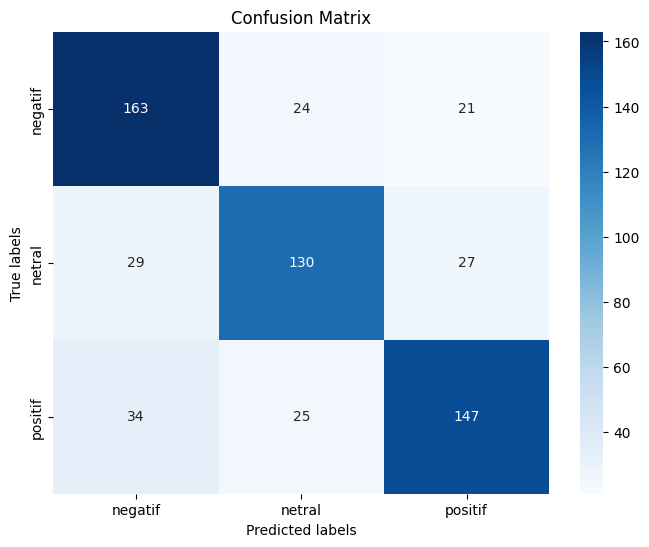

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat dan melatih model Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(tfidf_train_features, y_train_encoded)

# Memprediksi label untuk data uji
y_pred = naive_bayes_model.predict(tfidf_test_features)

# Menghitung akurasi prediksi
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Prediksi akurasi dari model: {:.2f}%".format(accuracy * 100))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


Tuning Model 

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

# Parameter grid untuk GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(tfidf_train_features, y_train_encoded)

print("Best parameters from GridSearchCV:", grid_search.best_params_)




Best parameters from GridSearchCV: {'alpha': 1.0, 'fit_prior': True}


In [13]:
# RandomizedSearchCV
param_dist = {
    'alpha': uniform(0.1, 2.0),
    'fit_prior': [True, False]
}

random_search = RandomizedSearchCV(MultinomialNB(), param_dist, cv=5, n_iter=10, random_state=42)
random_search.fit(tfidf_train_features, y_train_encoded)

print("Best parameters from RandomizedSearchCV:", random_search.best_params_)


Best parameters from RandomizedSearchCV: {'alpha': 0.849080237694725, 'fit_prior': True}


In [14]:
# Evaluasi model terbaik dari GridSearchCV
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(tfidf_test_features)
accuracy_grid = accuracy_score(y_test_encoded, y_pred_grid)
print("\nPrediksi akurasi dari model terbaik (GridSearchCV): {:.2f}%".format(accuracy_grid * 100))

# Evaluasi model terbaik dari RandomizedSearchCV
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(tfidf_test_features)
accuracy_random = accuracy_score(y_test_encoded, y_pred_random)
print("Prediksi akurasi dari model terbaik (RandomizedSearchCV): {:.2f}%".format(accuracy_random * 100))



Prediksi akurasi dari model terbaik (GridSearchCV): 73.33%
Prediksi akurasi dari model terbaik (RandomizedSearchCV): 73.17%


### Model SVM

Prediksi akurasi dari model SVM: 75.83%

Classification Report SVM:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       208
           1       0.80      0.75      0.77       186
           2       0.77      0.72      0.74       206

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600



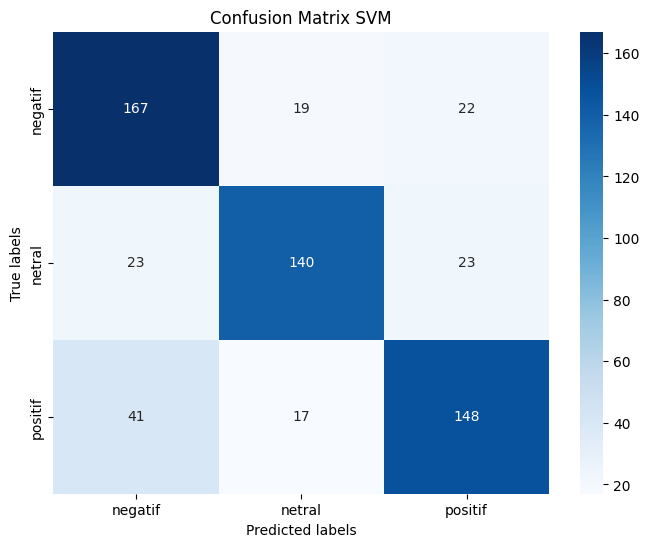

In [15]:
from sklearn.svm import SVC

# Membuat dan melatih model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(tfidf_train_features, y_train_encoded)

# Memprediksi label untuk data uji
y_pred_svm = svm_model.predict(tfidf_test_features)

# Menghitung akurasi prediksi
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
print("Prediksi akurasi dari model SVM: {:.2f}%".format(accuracy_svm * 100))

# Classification report
print("\nClassification Report SVM:")
print(classification_report(y_test_encoded, y_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix SVM")
plt.show()


In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

# Parameter grid untuk GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# GridSearchCV
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_search_svm.fit(tfidf_train_features, y_train_encoded)

print("Best parameters from GridSearchCV for SVM:", grid_search_svm.best_params_)



Best parameters from GridSearchCV for SVM: {'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [17]:
# RandomizedSearchCV
param_dist_svm = {
    'C': uniform(0.1, 100),
    'gamma': ['scale', 'auto'] + list(uniform(0.001, 1.0).rvs(10)),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

random_search_svm = RandomizedSearchCV(SVC(), param_dist_svm, cv=5, n_iter=10, random_state=42)
random_search_svm.fit(tfidf_train_features, y_train_encoded)

print("Best parameters from RandomizedSearchCV for SVM:", random_search_svm.best_params_)

Best parameters from RandomizedSearchCV for SVM: {'C': 0.8066305219717406, 'gamma': 0.388457837885682, 'kernel': 'linear'}


In [18]:
# Evaluasi model terbaik dari GridSearchCV
best_model_grid_svm = grid_search_svm.best_estimator_
y_pred_grid_svm = best_model_grid_svm.predict(tfidf_test_features)
accuracy_grid_svm = accuracy_score(y_test_encoded, y_pred_grid_svm)
print("\nPrediksi akurasi dari model terbaik (GridSearchCV) SVM: {:.2f}%".format(accuracy_grid_svm * 100))

# Evaluasi model terbaik dari RandomizedSearchCV
best_model_random_svm = random_search_svm.best_estimator_
y_pred_random_svm = best_model_random_svm.predict(tfidf_test_features)
accuracy_random_svm = accuracy_score(y_test_encoded, y_pred_random_svm)
print("Prediksi akurasi dari model terbaik (RandomizedSearchCV) SVM: {:.2f}%".format(accuracy_random_svm * 100))



Prediksi akurasi dari model terbaik (GridSearchCV) SVM: 75.83%
Prediksi akurasi dari model terbaik (RandomizedSearchCV) SVM: 75.67%


### Model Ensemble Learning

In [19]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = best_model_grid
best_model_svm = best_model_grid_svm


Prediksi akurasi dari model Ensemble: 74.67%

Classification Report Ensemble:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       208
           1       0.78      0.72      0.75       186
           2       0.80      0.69      0.74       206

    accuracy                           0.75       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600



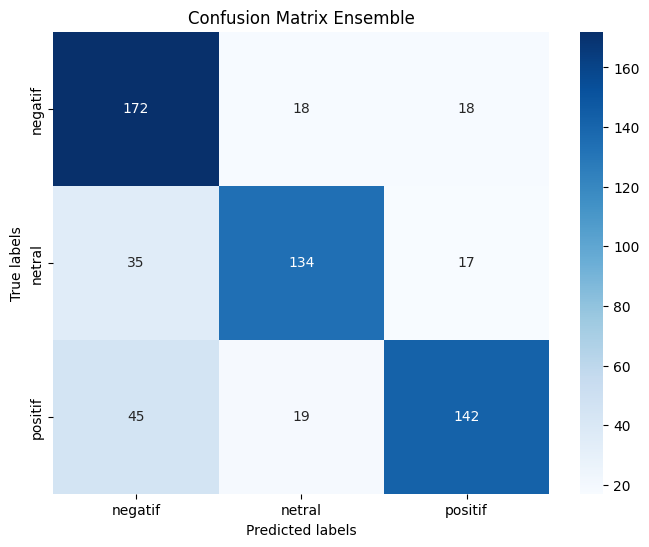

In [20]:
from sklearn.ensemble import VotingClassifier

# Membuat model ensemble
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
], voting='hard')

# Melatih model ensemble
ensemble_model.fit(tfidf_train_features, y_train_encoded)

# Memprediksi label untuk data uji
y_pred_ensemble = ensemble_model.predict(tfidf_test_features)

# Menghitung akurasi prediksi
accuracy_ensemble = accuracy_score(y_test_encoded, y_pred_ensemble)
print("Prediksi akurasi dari model Ensemble: {:.2f}%".format(accuracy_ensemble * 100))

# Classification report
print("\nClassification Report Ensemble:")
print(classification_report(y_test_encoded, y_pred_ensemble))

# Confusion matrix
cm_ensemble = confusion_matrix(y_test_encoded, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix Ensemble")
plt.show()
